# HCC case

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [2]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import modsum, model_features_chart, crossvalidation_as_framework


In [3]:
feyn.__version__

'2.1.2'

In [4]:
# Load the data
data = pd.read_csv("../data/cancer_hcc.csv")

In [5]:
data.shape

(91, 1713)

In [6]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

# Define the target variable
target = "target"

In [7]:
### get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

## Set multifigure filename

In [8]:
filename = '../figures/'

## In depth modelling 

In [9]:
projectname = 'hcc_mctaseq_epigenomics_'

In [10]:
pathname = '../figures/'

In [11]:
### Get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [12]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 15
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [13]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

In [14]:
def simple_str(m):
    return "logreg(" +  ''.join(list(map(lambda x:x[0:8], str(m)[7:-1].replace("*"," * ").split())))+")"

df_summary = modsum(models_single, train_val, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary['Functional form'] = df_summary['Functional form'].apply(simple_str)
df_summary.to_csv(filename+projectname+"summary.csv")
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(chr16676+chr17594+chr68783),11.67,0.021642,1.0
1,3,logreg(chr10131*chr17594+chrX3754),13.56,0.005101,1.0
2,3,logreg(chr16896+chr17594+chr61585),13.62,0.035156,1.0
3,3,logreg(chr10131*chr17594+chr11069),14.19,0.009462,1.0
4,3,logreg(chr11177+chr17594+chr51881),14.68,0.042525,1.0
5,2,logreg(chr17594+chr39987),14.72,0.072524,1.0
6,3,logreg(chr10131+chr17594+chr72324),14.75,0.043011,1.0
7,2,logreg(chr17594+chr68783),17.81,0.094013,0.99
8,3,logreg(chr17594+chr31195+chr39987),19.82,0.078207,1.0
9,3,logreg(chr17594+chr19495+chr61585),19.88,0.078681,1.0


In [15]:
print(df_summary.to_latex())

\begin{tabular}{lrllrl}
\toprule
{} &  N. Features &                     Functional form &    BIC &      Loss & AUC Train \\
\midrule
0 &            3 &  logreg(chr16676+chr17594+chr68783) &  11.67 &  0.021642 &       1.0 \\
1 &            3 &  logreg(chr10131*chr17594+chrX3754) &  13.56 &  0.005101 &       1.0 \\
2 &            3 &  logreg(chr16896+chr17594+chr61585) &  13.62 &  0.035156 &       1.0 \\
3 &            3 &  logreg(chr10131*chr17594+chr11069) &  14.19 &  0.009462 &       1.0 \\
4 &            3 &  logreg(chr11177+chr17594+chr51881) &  14.68 &  0.042525 &       1.0 \\
5 &            2 &           logreg(chr17594+chr39987) &  14.72 &  0.072524 &       1.0 \\
6 &            3 &  logreg(chr10131+chr17594+chr72324) &  14.75 &  0.043011 &       1.0 \\
7 &            2 &           logreg(chr17594+chr68783) &  17.81 &  0.094013 &      0.99 \\
8 &            3 &  logreg(chr17594+chr31195+chr39987) &  19.82 &  0.078207 &       1.0 \\
9 &            3 &  logreg(chr17594+chr19495+ch

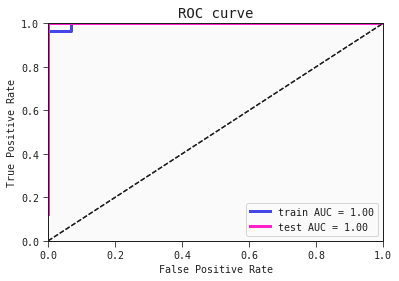

In [16]:
models_single[5].plot_roc_curve(train_val, label='train')
models_single[5].plot_roc_curve(test, label='test', ax=plt.gca())
plt.savefig(pathname+projectname+'roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

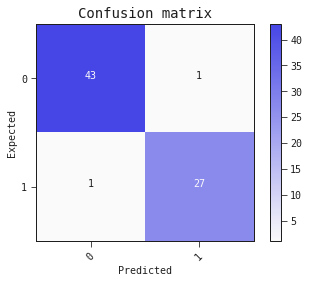

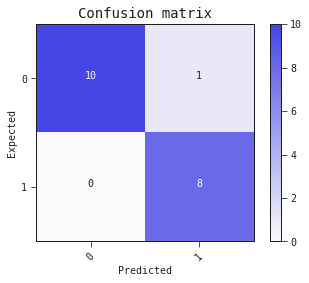

In [17]:
models_single[5].plot_confusion_matrix(train_val, filename=pathname+projectname+'confusion_train'+'.pdf')
models_single[5].plot_confusion_matrix(test, filename=pathname+projectname+'confusion_ttest'+'.pdf')

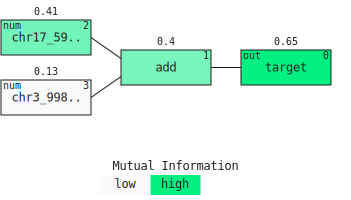

In [19]:
models_single[5].plot_signal(train_val, corr_func='mutual_information', 
                             filename=pathname+projectname+'plot_signal_mi.svg')

In [21]:
sympy_model = models_single[5].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(0.0179*exp(-0.111*chr175947306059483266 + 0.131*chr399878959989619) + 1)

In [22]:
features_data = train_val[models_single[5].features + ["target"]]

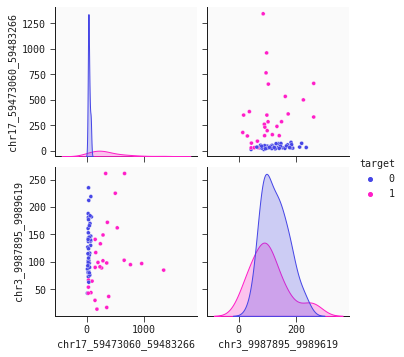

In [23]:
import seaborn as sns
# Pairplot with target coloring
sns.pairplot(features_data, hue = 'target')
plt.savefig(pathname+projectname+'pairplot.pdf')

In [24]:
features_data.columns

Index(['chr17_59473060_59483266', 'chr3_9987895_9989619', 'target'], dtype='object')

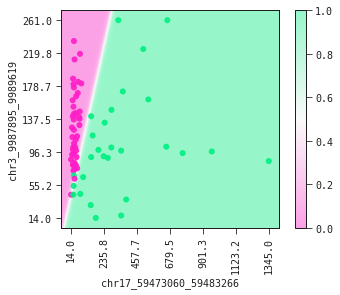

In [25]:
# Plot a 2-dimensional partial plot
models_single[5].plot_response_2d(features_data, filename=pathname+projectname+'plot_response_2d.pdf')

# Cross-validation as a framework

In [26]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = 5)

In [27]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean()

(0.9108116883116883, 0.8777777777777775)

In [28]:
# average performance of first model
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().accuracy_val.mean()

(0.9272727272727271, 0.8894736842105262)

In [39]:
results.groupby("fold").first().roc_auc_val.std()

0.09916160607179782

In [29]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(chr175947306059483266 + chr224901891749...,8.185402,12.738734,1.000000,1.000000,1.000000,0.947368,1.000000,0.727273,"add(add(""chr2_8816314_8817264"", ""chr22_4901891..."
1,logreg(chr175947306059483266*chr19173551811735...,6.117878,12.989256,1.000000,1.000000,1.000000,1.000000,1.000000,0.608696,"add(multiply(""chr17_59473060_59483266"", ""chr19..."
2,logreg(chr175947306059483266 + chr399878959989...,11.061667,13.352126,0.998433,0.958904,0.987013,0.888889,0.980867,0.636364,"add(""chr3_9987895_9989619"", ""chr17_59473060_59..."
3,logreg(chr167309688873097115 + log(chr12661351...,7.182855,11.763774,1.000000,0.986301,0.779221,0.777778,0.754550,0.608696,"add(log(""chr12_66135120_66136400""), ""chr16_730..."
4,logreg(chr1112524468112525385 + chr17594730605...,4.160200,6.450659,1.000000,1.000000,0.870130,0.833333,0.894855,0.608696,"add(""chr1_112524468_112525385"", ""chr17_5947306..."


In [30]:
for m in results.groupby('fold').first().model_structure:
    print(m)

logreg(chr175947306059483266 + chr224901891749019317 + chr288163148817264)
logreg(chr175947306059483266*chr191735518117356471 + chr28716917387170303)
logreg(chr175947306059483266 + chr399878959989619)
logreg(chr167309688873097115 + log(chr126613512066136400))
logreg(chr1112524468112525385 + chr175947306059483266)


# Correlation plot for article

In [31]:
models_single[5].features

['chr17_59473060_59483266', 'chr3_9987895_9989619']

In [32]:
# Take a random subset of 100 features
data_wo_target = data.drop('target', axis = 1)
sampled_features = np.unique(list(np.random.choice(data_wo_target.columns, 100, replace=False)) + models_single[5].features)
sample_data = data[sampled_features]

In [33]:
# Prepare for labelling the two model features in the heatmap
label_feature = list()

for x, i in enumerate(sampled_features):
    if i in models_single[5].features:
        label_feature.append(1)
    else: label_feature.append(0)

# Assign colors to chosen features
lut = dict({0: 'w',
           1: 'b'})

# Map colors to correlation data
row_coloring = pd.Series(label_feature, index = sample_data.corr().index).map(lut)

/Users/miqueltrianaiglesias/repos/qlattice-clinical-omics-paper/venv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


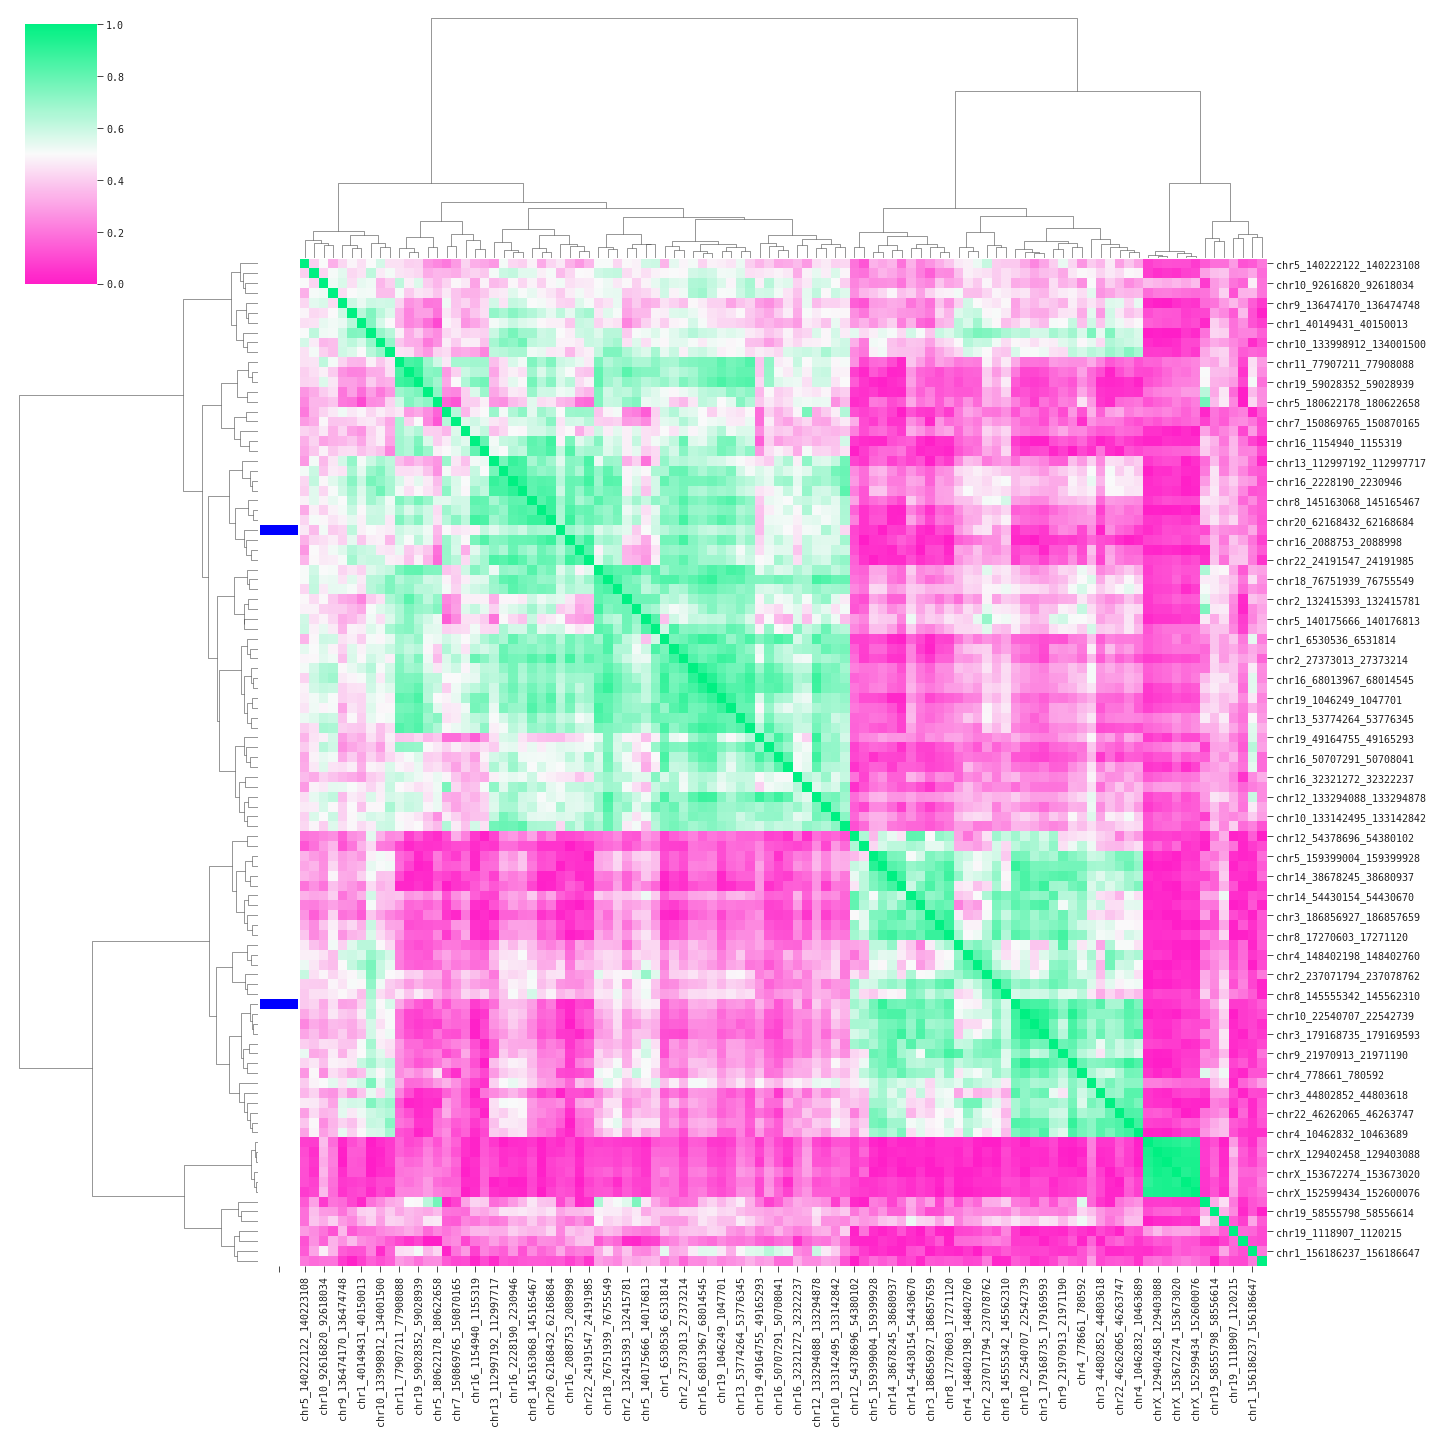

In [43]:
p = sns.clustermap(abs(sample_data.corr()), method="ward", cmap='feyn-diverging', row_colors = row_coloring,
               vmin=0, vmax=1, figsize=(20,20), robust=False)
p.savefig(filename+projectname+"clustermap.pdf")